In [1]:
import numpy as np
import pandas as pd
import sys
import os
import re
import csv
import collections as co
import itertools as it
import umap
import hdbscan
import time 
import progressbar
import math
import random
import fileinput

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import scipy.spatial.distance as ssd
import seaborn as sns

from Bio import Align, AlignIO, Phylo
from Bio.Align.Applications import MafftCommandline
from Bio.Seq import Seq 
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix, DistanceCalculator
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, SequenceFace
from IPython.display import display
from matplotlib import colors 
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from statistics import mean
from scipy import stats
from kneed import DataGenerator, KneeLocator

%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [2]:
class frequency(object):
    
    def __init__(self, k = 7, convert = 0):
    
        self.k = k
        self.convert = convert
        self.exist = co.defaultdict(int) 
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.row = 0
        self.matrix = np.empty((self.row, self.col, ),dtype = "float32")
        self.amino = co.defaultdict(str, {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F'
        })
                
    def translate(self, read):
    
        chain = ''

        for i in range(len(read) - 2):
            trip = read[i:i+3]
            chain += self.amino[trip]

        return(chain)
    
    
    def adjust_to_data(self, infile):
    
        self.row = infile.shape[0]
            
        for line, read in infile.itertuples(index=True, name=None):

            if self.convert == 1:
                seq = self.translate(read)
                del read

                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    self.exist[kmer] = 0

            else:
                seq = read
                del read

                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        self.exist[kmer] = 0
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            self.exist[kmer] = 0
            
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.matrix = np.empty((self.row, self.col, ), dtype="float32")
        
        del seq
    
    
    def calculate_frequence(self, infile):
        
        for line, read in infile.itertuples(index=True, name=None): 
                 
            if self.convert == 1:
                seq = self.translate(read)
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    counts[kmer] += 1

            else:
                seq = read
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        counts[kmer] += 1
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            counts[kmer] += 1

            vector = np.array(list(counts.values()), dtype = "float32")

            self.matrix[line] = vector/vector.sum()
            
            counts.clear()
            del vector
            del seq
            del counts
    
    
    def get_keys(self):
        
        return(self.keys)
    
    
    def get_matrix(self):
        
        return(self.matrix)

In [3]:
def subsplit(subtype):
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)

In [4]:
def convert_fasta(infile, outfile):

    #with some help from https://stackoverflow.com/questions/50856538/how-to-convert-multiline-fasta-files-to-singleline-fasta-files-without-biopython
    
    with open(infile) as f_input, open(outfile, 'w') as f_output:

        block = []

        for line in f_input:
    
            if line.startswith('>'):

                if block:
                    f_output.write(new_line + ',' + "".join(block) + '\n')
                    block = []
                
                new_line = line.strip().replace('|', ',')
            else:
                block.append(line.strip())
    
        if block:
            f_output.write(new_line + ',' + "".join(block) + '\n')

In [5]:
def get_vectors(sequence, accession, metric, neigh, comp, pca):

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    #Kevins approach
    #freq = frequency(k = 7)
    #freq.calculate_frequence(sequence)
    
    if pca:
        matrix = freq.get_matrix()
        pca_init = PCA(n_components=pca)
        pca_matr = pca_init.fit_transform(matrix)
        #pca_matr = freq.get_matrix()

        dataframe_pca = pd.concat([accession, pd.DataFrame(pca_matr)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        pca_matr = freq.get_matrix()
        dataframe_pca = pd.DataFrame()
    
    #Dimension Reduction with UMAP
    if pca and pca <= comp:
        reduced = pca_matr
    else:
        reduced = umap.UMAP(
            n_neighbors = neigh,
            min_dist = 0.0,
            n_components = comp,
            random_state = 42,
            metric = metric,
        ).fit_transform(pca_matr)

    #approximation of cosine by l2 normalization (https://github.com/scikit-learn-contrib/hdbscan/issues/69)
    if metric == 'cosine':
        cos_red = normalize(reduced, norm='l2')
        dataframe = pd.concat([accession, pd.DataFrame(cos_red)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        dataframe = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    return(dataframe, dataframe_pca)

In [6]:
def get_elbow(dataframe, extra, accession, metric, algo, sample, area = (0,500)):
    
    #with some help from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = 2,
        gen_min_span_tree = True,
        metric = metric,
        algorithm = algo,
    ).fit(dataframe)
    
    label = clusterer_best.labels_
    label_list = label.tolist()
    n_cluster = len(set(label_list))-1
    
    linkage = clusterer_best.single_linkage_tree_.to_pandas()
    numpy_linkage = linkage.drop(columns=['parent']).to_numpy()
    
    dist = numpy_linkage[:, 2]
    dist_rev = dist[::-1]
    
    if area == -1:
        dist_area = dist_rev[area[0]:n_cluster]
    else:
        dist_area = dist_rev[area[0]:area[1]]
    
    idxs = np.arange(1, len(dist_area) + 1)

    kn = KneeLocator(idxs, dist_area,
        curve='convex',
        direction='decreasing',
        interp_method='polynomial',
        online=True,
        S = 1.0,
    )
    
    n_cluster_raw = kn.knee
    n_cluster_norm = kn.norm_knee
    
    #linkage.set_index('parent', inplace = True)
    elbow = pd.DataFrame({'n_cluster': idxs, 
                          'distance': dist_area, 
                          'x_normalized':kn.x_normalized, 
                          'y_normalized':kn.y_normalized, 
                          'x_difference':kn.x_difference, 
                          'y_difference':kn.y_difference}).set_index('n_cluster')
    epsilon_best = elbow.loc[n_cluster_raw][['distance']].item()
    linkage.set_index('parent', inplace = True)
    
    return(linkage, elbow, epsilon_best, n_cluster_raw, n_cluster_norm)

In [7]:
def get_cluster(epsilon_best, dataframe, extra, accession, metric, algo, sample):
    
    #approximation see above
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = 2,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        metric = metric,
        algorithm = algo,
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    n_cluster = len(set(label_list))-1
    unclustered = label_list.count(-1)
    
    cluster = pd.concat([pd.DataFrame(label, columns = ['cluster']), extra, accession], axis=1, copy = False).set_index('accession')
    #linkage = clusterer_best.single_linkage_tree_.to_pandas()
    #linkage.set_index('parent', inplace = True)
    
    N_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['N'].replace('', np.nan).nunique() > 1).cluster.nunique()
    H_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['H'].replace('', np.nan).nunique() > 1).cluster.nunique() 
    
    cluster.insert(2, 'centroid', False)

    num = cluster['cluster'].max()+1
    values = [True]*num
    accessions = []

    for i in range(num):

        query = cluster[cluster.cluster == i]
        match = query.index.values.tolist()
        sub = dataframe.filter(items = match, axis=0)
        dist = ssd.cdist(sub, sub, metric = metric)
        inner_mean = pd.DataFrame(dist, columns = match, index = match, dtype = 'float32').mean()
        accessions.append(inner_mean.idxmin())

    cluster.update(pd.DataFrame(values, columns=['centroid'], index = accessions))
    
    return(cluster, n_cluster, unclustered, H_unmatch, N_unmatch)

In [8]:
def plot_density(density, segments, outpath, accuracy):

    for seg in segments:
            
        sns.set_style("dark")
        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize = (8, 4), squeeze = False)
        
        sns.histplot(data = density.query('segment == @seg'), x = "size", kde=False, log_scale=False, element="step", fill = True, bins = round(density.query('segment == @seg')['size'].max()*accuracy), ax = axs[0,0])

        axs[0, 0].grid()
        #axs[0, 0].set_title("");
        axs[0, 0].set_xlabel("Count");
        axs[0, 0].set_ylabel("#Cluster");

        sns.histplot(data = density.query('segment == @seg'), x = "size", kde=False, log_scale=True, element="step", fill = True, bins = round(density.query('segment == @seg')['size'].max()*accuracy), ax = axs[0, 1])

        axs[0, 1].grid()
        #axs[0, 1].set_title("");
        axs[0, 1].set_xlabel("log(Count)");
        axs[0, 1].set_ylabel("#Cluster");
    
        plt.tight_layout()
        plt.savefig(outpath + 'Cluster_Distribution_Segment_' + str(seg) + '.pdf')
        plt.show()

In [9]:
def plot_normalization(upload, segment, n, outpath):
    
    subset = upload.query('segment == @segment').sample(n=n).reset_index()
    sequence = subset[['genome']].copy()
    accession = subset[['accession']].copy()

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    matrix = freq.get_matrix()
    keys = freq.get_keys()

    reduced_cos = umap.UMAP(
        metric = 'cosine',
        n_components = 2
    ).fit_transform(matrix)

    dataframe_pre_cos = pd.concat([accession, pd.DataFrame(reduced_cos)], axis=1, copy = False, ignore_index = False).set_index('accession')
    dataframe_pre_cos.insert(0, "method", 'cosine', True)

    matrix_pre_l2 = normalize(matrix, norm='l2')

    reduced_l2 = umap.UMAP(
        metric = 'euclidean',
        n_components = 2
    ).fit_transform(matrix_pre_l2)

    dataframe_pre_l2 = pd.concat([accession, pd.DataFrame(reduced_l2)], axis=1, copy = False, ignore_index = False).set_index('accession')
    dataframe_pre_l2.insert(0, "method", 'l2 + euclidean', True)

    dataframe_pre = pd.concat([dataframe_pre_cos, dataframe_pre_l2], axis = 0).reset_index()
    dataframe_pre.rename(columns = {0: "x", 1:"y"}, inplace=True)

    sns.set()
    
    g = sns.relplot(data=dataframe_pre, x="x", y="y", col="method", height=4, kind="scatter")
    g.set_axis_labels("x", "y")
    g.set_titles("{col_name}")
    g.tight_layout()

    plt.tight_layout()
    plt.savefig(outfolder + 'Difference_Dimension_Reduction.pdf')
    plt.show() 
    
    reduced = umap.UMAP(
        n_components = 20,
        metric = 'cosine',
    ).fit_transform(matrix)

    reduced_post_l2 = normalize(reduced, norm='l2')
    
    dataframe_post_l2 = pd.concat([accession, pd.DataFrame(reduced_post_l2)], axis=1, copy = False, ignore_index = False).set_index('accession')
    dataframe_post_cos = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    dist_eucl = ssd.cdist(dataframe_post_l2, dataframe_post_l2, metric = 'euclidean')
    dist_cos = ssd.cdist(dataframe_post_cos, dataframe_post_cos, metric = 'cosine')
    
    list_cos = []
    list_eucl = []

    x = [list_cos.extend(line[:i].tolist()) for i, line in enumerate(dist_cos)]
    y = [list_eucl.extend(line[:i].tolist()) for i, line in enumerate(dist_eucl)]

    xs = np.array(list_cos, dtype=np.float64)
    ys = np.array(list_eucl, dtype=np.float64)
    
    regression = stats.linregress(xs, ys)
    #m, b = best_fit_slope_and_intercept(xs,ys)
    regression_line = [(regression.slope*x)+regression.intercept for x in xs]
    #r_squared = coefficient_of_determination(ys,regression_line)
    r_squared = regression.rvalue**2

    sns.set()
    plt.figure(figsize=(8,4))
    sns.scatterplot(data = pd.DataFrame(zip(list_cos, list_eucl), columns = ['cosine', 'euclidean']), x="cosine", y="euclidean")
    sns.lineplot(data = pd.DataFrame(zip(xs.tolist(), regression_line), columns = ['x', 'y']), x = 'x', y = 'y', color = "r", alpha=.5)
    plt.xlabel("cosine")
    plt.ylabel("l2 + euclidean")
    plt.title("correlation");
    plt.tight_layout()
    plt.savefig(outfolder + 'Difference_Distance_Calculation.pdf')
    plt.show() 
    
    print(f'R2 Coefficient: {r_squared}.')

In [10]:
def plot_elbow(elbow, information, segments, outfolder):

        
    for seg in segments:
    
        sns.set_style("dark")
        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize = (8, 4), squeeze = False)

        sns.lineplot(data = elbow.query('segment == @seg'), x = "n_cluster", y = "distance", ax = axs[0, 0])

        y_max = elbow.query('segment == @seg')['distance'].max().item()
        x_max = elbow.query('segment == @seg')['n_cluster'].max().item()

        y_note = information.query('segment == @seg')['epsilon'].item()
        x_note = information.query('segment == @seg')['n_cluster_raw'].item()

        axs[0, 0].axhline(y = y_note, alpha=.5, color="r")
        axs[0, 0].axvline(x = x_note, alpha=.5, color="r")

        axs[0, 0].text(x_max*0.9, y_note, f"{y_note:0.3f}", va='bottom', color = "r", alpha=.5)
        axs[0, 0].text(x_note, y_max*0.9, f"{x_note:0.0f}", rotation='vertical', ha='right', color = "r", alpha=.5)

        axs[0, 0].grid()
        #axs[0, 0].set_title("");
        axs[0, 0].set_xlabel("#Cluster");
        axs[0, 0].set_ylabel("Distance");
        
        sns.lineplot(data = elbow.query('segment == @seg'), x = "x_normalized", y = "y_normalized", ax = axs[0, 1])
        sns.lineplot(data = elbow.query('segment == @seg'), x = "x_difference", y = "y_difference", color="g", ax = axs[0, 1])
        
        x2_note = information.query('segment == @seg')['n_cluster_norm'].item()
        axs[0, 1].axvline(x = x2_note, alpha=.5, color="r")
        axs[0, 1].text(x2_note, 0, f"{x2_note:0.3f}", rotation='vertical', ha='right', color = "r", alpha=.5)
        
        axs[0, 1].grid()
        #axs[0, 1].set_title("");
        axs[0, 1].set_xlabel("norm(#Cluster)");
        axs[0, 1].set_ylabel("Difference");
        
        plt.tight_layout()
        plt.savefig(outfolder + 'Cluster_Elbow_Segment_' + str(seg) + '.pdf')
        plt.show()

In [11]:
#https://github.com/scipy/scipy/issues/8274
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [12]:
def view_fasta(data):
    
    bundle = {}
    bundle['application/vnd.fasta.fasta'] = data
    bundle['text/plain'] = data
    display(bundle, raw=True)

In [13]:
def alignment(fasta, threads, outfasta, outmsa):    

    fasta.to_csv(outfasta, header=None, index=True, sep='\n', mode='w')

    mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = True)
    #mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = False)
    stdout, stderr = mafft_cline()

    #os.remove('tmp.fasta') 
    with open(outmsa, "w") as handle:
        handle.write(stdout)
    
    return(stdout)

In [14]:
def fasta_alignment(centroid, segment, threads, outfasta, outmsa):
    
    fasta = centroid.query('segment == @segment').reset_index().drop(['segment', 'H', 'N'], axis=1)
    #fasta = centroid.query('segment == 4 & centroid == True').merge(genome, on = 'accession')[['cluster', 'genome']].reset_index().set_index('cluster').filter(items = cluster_list, axis=0).reset_index()
    fasta['name'] = '>Cluster ' + fasta.cluster.astype(str)
    fasta.drop(columns=['accession', 'cluster'], inplace = True)
    fasta.set_index('name', inplace = True)

    msa = alignment(fasta, threads, outfasta, outmsa)
    #tree = tree_X.copy()

    #tree = plot_alignment(msa, tree)
    #cluster_list = choice of clusters from the alignment (second choice)
    #start/stop = choice of nucleotides in the choosen alignment lines (third choice)

    #tree = plot_alignment(msa, tree, [], 0, -1)
    #tree = plot_alignment(msa, tree, cluster_list, start, end)
    
    return(msa)

In [15]:
def pairmsa(nuc1, nuc2):
        
    seq1 = Seq(nuc1.item()) 
    seq2 = Seq(nuc2.item()) 

    aligner = Align.PairwiseAligner()
    alignments = aligner.align(seq1, seq2) 
    
    #alignments = pairwise2.align.globalmx(seq1, seq2, 1, -1) 
    
    return(alignments[0].score)

In [16]:
def fill_gaps(group, protein):
    
    set_protein = set(group[protein].tolist())
    if '' in set_protein:
        set_protein.discard('')
    if len(set_protein) == 1:
        group['protein'] = list(set_protein)[0]
    else:
        group['protein'] = group[protein]
        group['protein'].replace('', 'mixed', inplace = True)
        group['protein'].fillna('mixed', inplace = True)
        
    return(group)

In [17]:
def get_acc(dictionary_tree, list_value):
    list_accessions = []
    for key, value in dictionary_tree.items():
         if value in list_value:
            list_accessions.append(key)
    return(list_accessions)

In [18]:
def layout(node):
    
    if node.is_leaf():
        N = AttrFace("name", fsize=10)
        faces.add_face_to_node(N, node, 0, position="aligned")
    
        M = AttrFace("size", fsize=10, text_prefix='|Size ', text_suffix='|')
        faces.add_face_to_node(M, node, 1, position="aligned")    

In [19]:
def get_tree(cluster, upload, segment, protein, list_color_hex, list_prune = [], list_focus = [], collapse = True, path_phylo = '', msa_dict = co.defaultdict(str), area = [], linkage = pd.DataFrame()):

    #Dataframes Creation and Correction
    dataframe_tree_query = cluster.query('segment == @segment').join(upload.set_index('accession')[['host', 'date']])[['cluster', protein, 'host', 'date']]
    dataframe_tree_corr = dataframe_tree_query.groupby('cluster').apply(fill_gaps, protein = protein).drop(protein, axis = 1)
    dictionary_tree = dataframe_tree_corr.to_dict()
    list_tree_label = dataframe_tree_corr.index.values

    #Tree Backbone Creation:
    tree_style = TreeStyle()
    
    if not path_phylo and not linkage.empty:
        array_tree_link = linkage.query('segment == @segment').drop(columns=['segment', 'parent']).to_numpy()
        tree_hierarchy = hierarchy.to_tree(array_tree_link, False)
        tree_newick = getNewick(tree_hierarchy, "", tree_hierarchy.dist, list_tree_label)
        tree = Tree(tree_newick)
    
    elif path_phylo and linkage.empty:    
        tree = Tree(path_phylo)
        for leaf in tree.iter_leaves():
            leaf_name = leaf.name.split('_')[1]
            if not leaf_name == 'Cluster':
                leaf.name = '>' + leaf_name
            else:
                leaf.name = leaf.name.split('_')[2]
                
    else:
        print('Linkage Tree and Phylo Tree both or none given. Empty Tree generated.')
        tree = Tree()
        return(tree, tree_style)
        
    #General Appereance Settings:
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"

    #List and Dictionary Creation
    dict_color_protein = co.defaultdict(str)
    list_cluster = list(set(dictionary_tree['cluster'].values()))
    list_protein = list(set(dictionary_tree['protein'].values()))
    list_host = list(set(dictionary_tree['host'].values()))

    #Initial Leaf Settings:
    for leaf in tree.iter_leaves():
        if leaf.name.startswith('>'):
            leaf.host = dictionary_tree['host'].get(leaf.name, "none")
            leaf.date = dictionary_tree['date'].get(leaf.name, "none")
            leaf.cluster = dictionary_tree['cluster'].get(leaf.name, "none")
            leaf.protein = dictionary_tree['protein'].get(leaf.name, "mixed")
            leaf.name = leaf.name[1:]
            leaf.accession = True
        else:
            leaf_member = get_acc(dictionary_tree['cluster'], [int(leaf.name)])
            leaf.protein = dictionary_tree['protein'].get(leaf_member[0], "mixed")
            leaf.size = len(leaf_member)
            leaf.accession = False
    
    #Cluster Node Creation and Settings:
    if -1 in list_cluster:
        list_cluster.remove(-1)

    list_cluster_existing = []
    for cluster in list_cluster:
        try:
            list_member = tree.search_nodes(cluster=cluster)
            node_cluster = tree.get_common_ancestor(list_member)
            node_cluster.name = str(cluster)
            node_cluster.accession = False
            node_cluster.size = len(list_member)
            list_cluster_existing.append(cluster)
        except:
            pass
            
    #Serotype Coloring (maybe include mixed in the coloring):
    if 'mixed' in list_protein:
        list_protein.remove('mixed')

    for protein in list_protein:
        for tree_protein in tree.get_monophyletic(values=[protein], target_attr = "protein"):
            for node_protein in tree_protein.traverse():
                color = list_color_hex[int(protein[1:])-1]
                node_protein.img_style['bgcolor'] = color
                dict_color_protein[color] = protein

    #Host Monophyletic Lines Drawing:
    for host in list_host:
        for tree_host in tree.get_monophyletic(values=[host], target_attr = "host"):
            for node_host in tree_host.traverse():
                node_host.img_style["vt_line_type"] = 1
                node_host.img_style["hz_line_type"] = 1

    #Pruning according to Settings:
    if not list_prune:
        if not list_focus:
            if collapse == True:
                list_prune = list(map(str, list_cluster_existing))
        else:
            list_prune = [accession[1:] for accession in get_acc(dictionary_tree['cluster'], list_focus)]
            if collapse == False:
                list_prune.extend(list(map(str, list(set(list_cluster_existing).difference(set(list_focus))))))
    
    if list_prune:
        try:
            tree.prune(list_prune)
        except:
            print('No pruning performed.')

    #Creation and Coloring of Legend:
    column = 0
    for color_hex in list_color_hex:
        if color_hex in dict_color_protein:
            face_protein = TextFace(dict_color_protein[color_hex])
            face_protein.margin_top = 10
            face_protein.margin_right = 10
            face_protein.margin_left = 10
            face_protein.margin_bottom = 10
            face_protein.border.width = 1
            face_protein.background.color = color_hex
            tree_style.legend.add_face(face_protein, column=column)
            column += 1

    #Final Global Layout Settings
    #tree_style.layout_fn = layout
    for leaf in tree:
        if leaf.accession == True:
            leaf.add_face(AttrFace("cluster", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned")
            leaf.add_face(AttrFace("date", fsize=10, text_prefix='Date: '), 2, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 3, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 3, position="aligned")
        else:
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("size", fsize=10, text_prefix='|Size: ', text_suffix='|'), 1, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 2, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 2, position="aligned")
        
    tree_style.show_leaf_name = False
    tree_style.draw_guiding_lines = True
    tree_style.guiding_lines_color = 'black'
    tree_style.legend_position = 1
    
    if not msa_dict:
        tree_style.mode = "c"

    return(tree, tree_style)

In [20]:
def dict_alignment(msa, reduce = True, treshold = 1):
    
    if reduce == False:
        msa_dict = co.defaultdict(str)
        for line in msa.split('\n'):
            if line.startswith('>'):
                header = line[1:]
            else:
                msa_dict[header] += line

        return(msa_dict)
    
    else:
        msa_dict = co.defaultdict(list)
        for line in msa.split('\n'):
            if line.startswith('>'):
                header = line
            else:
                msa_dict[header] += line
                
        df = pd.DataFrame.from_dict(msa_dict, orient='index')
        
        #nunique = df.apply(pd.Series.nunique)
        nunique = df.apply(lambda x : x.value_counts(normalize=True)[0], axis=0)
        #drop = nunique[nunique == 1].index
        drop = nunique[nunique >= treshold].index
        df.drop(drop, axis=1, inplace=True)
        df['genome'] = df[df.columns[1:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)

        msa_red = df['genome'].reset_index().to_string(header=None, index=False).replace(' ', '\n')
        
        msa_dict_red = co.defaultdict(str)
        for line_red in msa_red.split('\n'):
            if line_red.startswith('>'):
                header_red = line_red[1:]
            else:
                msa_dict_red[header_red] += line_red

        return(msa_dict_red)

In [21]:
def check_error(cluster, number, protein, segment, outfolder):

    fasta_dict = co.defaultdict(list)
    if protein[0] == 'H':
        subtype = list(set(cluster.query('segment == @segment & cluster == @number')['H'].tolist()) - set(['', protein]))
        #accession = cluster.query('segment == @segment & cluster == @number & H in @subtype').index.item()

        fasta_dict[protein] = cluster.query('segment == @segment & cluster == @number & H not in @subtype').head(3)
        for sub in subtype:
            fasta_dict[sub] = cluster.query('segment == @segment & H == @sub').head(3)

        fasta_dict['miss'] = cluster.query('segment == @segment & cluster == @number & H in @subtype')  

    elif protein[0] == 'N':
        subtype = list(set(cluster.query('segment == @segment & cluster == @number')['N'].tolist()) - set(['', protein]))
        #accession = cluster.query('segment == @segment & cluster == @number & H in @subtype').index.item()

        fasta_dict[protein] = cluster.query('segment == @segment & cluster == @number & N not in @subtype').head(3)
        for sub in subtype:
            fasta_dict[sub] = cluster.query('segment == @segment & N == @sub').head(3)

        fasta_dict['miss'] = cluster.query('segment == @segment & cluster == @number & N in @subtype')      
    
    fasta = pd.concat(fasta_dict)
    fasta.index.set_names(["subtype", "accession"], inplace=True)
    fasta.reset_index(level = "subtype", inplace=True, drop = True)
    
    align = fasta.join(genome)[['genome']]
    
    name = 'segment_' + str(segment) + '_cluster_' + str(number)
    
    msa = alignment(align, 6, outfolder + name + '.fasta', outfolder + name + '.msa')
    msa_dict = dict_alignment(msa, reduce = True, treshold = 1)

    tree, tree_style = get_tree(cluster, upload, segment, protein[0], tree_hex, collapse = False, path_phylo = outfolder + name + '.fasta.tree', msa_dict = msa_dict)
    tree.render(outfolder + name + '.pdf', tree_style = tree_style)

# Pipeline

In [22]:
#settings
infile = 'A.fasta'
outfolder = 'PCA/'
create = 0
#segments = [1,2,3,4,5,6,7,8]
segments = [4, 6]
Hs = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18']
Ns = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11']
metric = 'cosine'
algo = 'best'
sample = 1
tree_hex = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5']

In [23]:
if not outfolder.endswith("/"):
    outfolder += "/"

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)
    
if create == 1:
    for f in os.listdir(outfolder):
        os.remove(os.path.join(outfolder, f))   

#Convert the Fasta to Csv
convert_fasta(infile, outfolder + 'fasta.csv')

#Dict Creation
dataframe_pca_dict = co.defaultdict(list)
dataframe_dict = co.defaultdict(list)
cluster_dict = co.defaultdict(list)
information_dict = co.defaultdict(list)
linkage_dict = co.defaultdict(list)
elbow_dict = co.defaultdict(list)

#Upload Fasta
upload = pd.read_csv(outfolder + 'fasta.csv', sep = ',', na_filter = False, header = None)
upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
upload.query('curation == "Pass"', inplace = True)
upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()
upload.to_csv(outfolder + 'upload.csv', index=False, header=True, sep=',', mode='w')

genome = upload[['accession', 'genome']].copy()
genome.set_index('accession', inplace = True)

In [24]:
try:
    
    dataframe_pca = pd.read_csv(outfolder + 'dataframe_pca.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    dataframe = pd.read_csv(outfolder + 'dataframe.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    cluster = pd.read_csv(outfolder + 'cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    genome = pd.read_csv(outfolder + 'genome.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    linkage = pd.read_csv(outfolder + 'linkage.csv', sep = ',', na_filter = False, header = 0)
    information = pd.read_csv(outfolder + 'information.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    density = pd.read_csv(outfolder + 'density.csv', sep = ',', na_filter = False, header = 0)
    elbow = pd.read_csv(outfolder + 'elbow.csv', sep = ',', na_filter = False, header = 0)

except:
    
    #Progress Variables
    widgets = [' [', progressbar.Timer(format = 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ] 
    bar = progressbar.ProgressBar(max_value = len(segments), widgets = widgets).start() 

    #Pipeline
    for progress, segment in enumerate(segments, 1):

        subset = upload.query('segment == @segment').reset_index()
        sequence = subset[['genome']].copy()
        accession = subset[['accession']].copy()
        extra = subset[['H', 'N', 'strain']].copy()

        dataframe_dict[segment], dataframe_pca_dict[segment] = get_vectors(sequence, accession, metric, 100, 30, 30)
        linkage_dict[segment], elbow_dict[segment], epsilon_best, n_cluster_raw, n_cluster_norm = get_elbow(dataframe_dict[segment], extra, accession, metric, algo, sample)
        cluster_dict[segment], n_cluster, unclustered, H_unmatch, N_unmatch = get_cluster(epsilon_best, dataframe_dict[segment], extra, accession, metric, algo, sample)
        information_dict[segment] = [n_cluster, n_cluster_raw, n_cluster_norm, unclustered, H_unmatch, N_unmatch, epsilon_best]
        
        bar.update(progress)

    bar.finish()    

    ########################################################################################################
    
    dataframe_pca = pd.concat(dataframe_pca_dict)
    dataframe_pca.index.set_names(["segment", "accession"], inplace=True)
    dataframe_pca.reset_index(level = "segment", inplace=True, drop = True)
    
    dataframe = pd.concat(dataframe_dict)
    dataframe.index.set_names(["segment", "accession"], inplace=True)
    dataframe.reset_index(level = "segment", inplace=True, drop = True)
    
    cluster = pd.concat(cluster_dict)
    cluster.index.set_names(["segment", "accession"], inplace=True)
    cluster.reset_index(level = "segment", inplace=True)
    
    linkage = pd.concat(linkage_dict)
    linkage.index.set_names(["segment", 'parent'], inplace=True)
    linkage.reset_index(level = ["segment", 'parent'], inplace=True)

    
    information = pd.DataFrame.from_dict(information_dict, orient='index', columns=['n_cluster', 'n_cluster_raw', 'n_cluster_norm', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon'])
    information.index.set_names(["segment"], inplace=True)
    
    elbow = pd.concat(elbow_dict)
    elbow.index.set_names(['segment', 'n_cluster'], inplace=True)
    elbow.reset_index(level = ["segment", "n_cluster"], inplace=True)
    
    density = pd.DataFrame(cluster.value_counts(subset=['segment', 'cluster']), columns = ['size'])
    density.reset_index(level = ["segment", "cluster"], inplace=True)
    
    ########################################################################################################
    
    dataframe_pca.to_csv(outfolder + 'dataframe_pca.csv', index=True, header=True, sep=',', mode='w')
    dataframe.to_csv(outfolder + 'dataframe.csv', index=True, header=True, sep=',', mode='w')
    
    cluster.to_csv(outfolder + 'cluster.csv', index=True, header=True, sep=',', mode='w')
    genome.to_csv(outfolder + 'genome.csv', index=True, header=True, sep=',', mode='w')
    information.to_csv(outfolder + 'information.csv', index=True, header=True, sep=',', mode='w')
    
    elbow.to_csv(outfolder + 'elbow.csv', index=False, header=True, sep=',', mode='w')
    density.to_csv(outfolder + 'density.csv', index=False, header=True, sep=',', mode='w')
    linkage.to_csv(outfolder + 'linkage.csv', index=False, header=True, sep=',', mode='w')

# Statistics

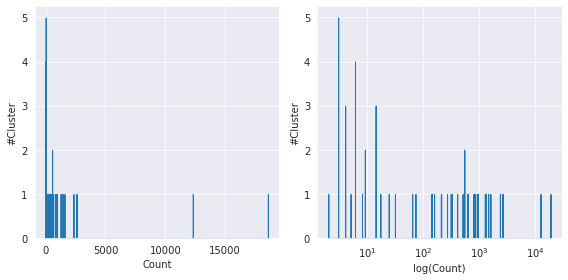

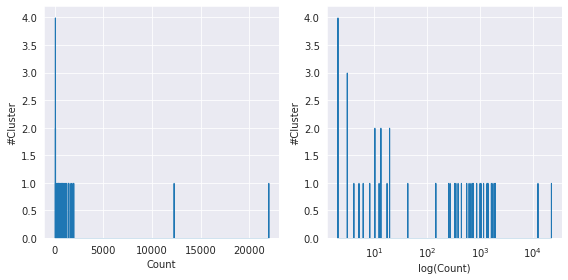

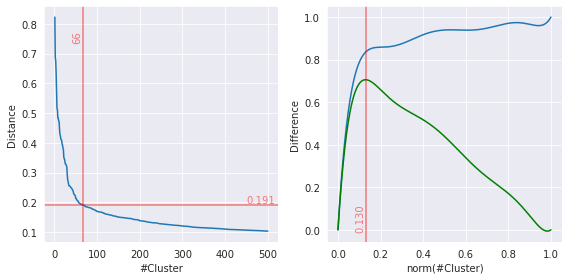

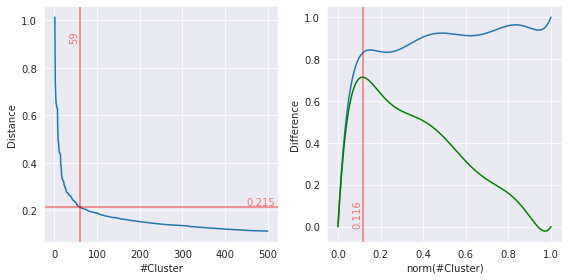

In [25]:
plot_density(density, segments, outfolder, 1)
plot_elbow(elbow, information, segments, outfolder)

# L^2 Normalisation

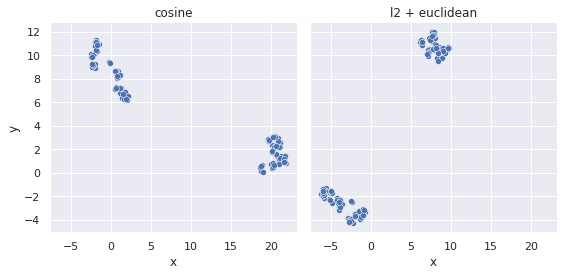

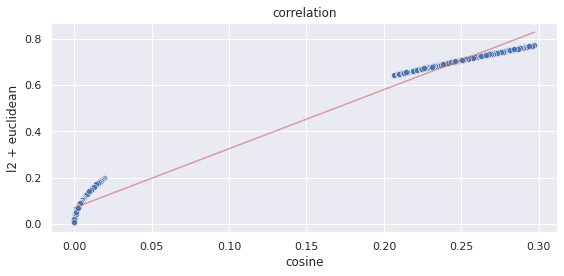

R2 Coefficient: 0.9908854609264914.


In [26]:
if metric == 'cosine':
    plot_normalization(upload, 4, 100, outfolder)

# Clustertrees

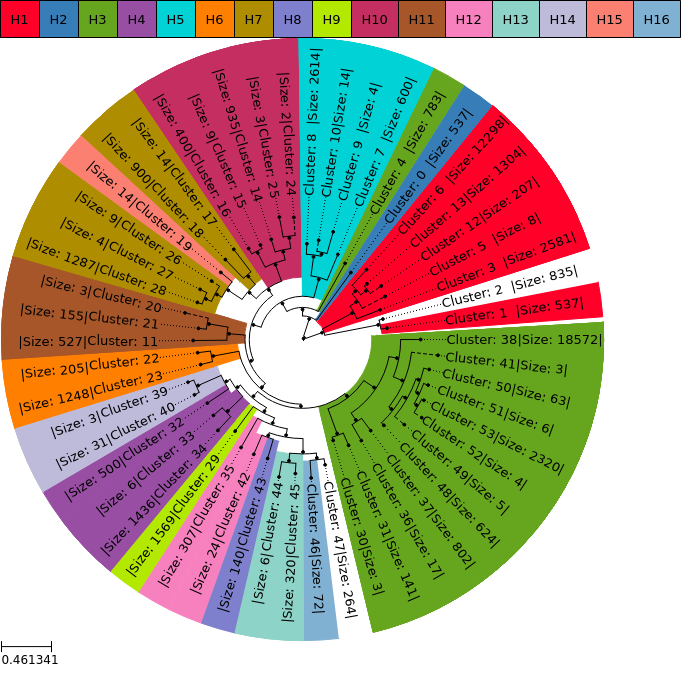

In [27]:
tree_H, ts_H = get_tree(cluster, upload, 4, 'H', tree_hex, linkage = linkage)
tree_H.render(outfolder + 'Clustertree_H.pdf', tree_style = ts_H)
tree_H.render('%%inline', tree_style = ts_H)

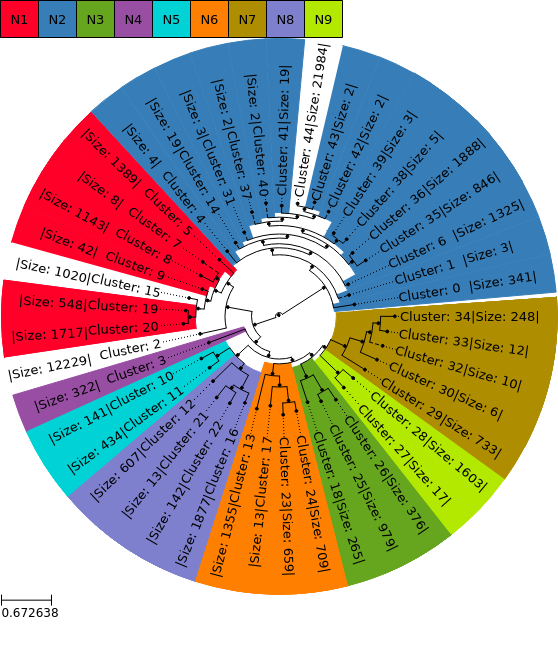

In [28]:
tree_N, ts_N = get_tree(cluster, upload, 6, 'N', tree_hex, linkage = linkage)
tree_N.render(outfolder + 'Clustertree_N', tree_style = ts_N)
tree_N.render('%%inline', tree_style = ts_N)

# Mixed Clusters

In [29]:
check_error(cluster, 2, "H1", 4, outfolder)

In [30]:
check_error(cluster, 47, "H16", 4, outfolder)

In [31]:
check_error(cluster, 44, "N2", 6, outfolder)

In [32]:
check_error(cluster, 2, "N1", 6, outfolder)

In [33]:
check_error(cluster, 15, "N1", 6, outfolder)

# MSA Guidetrees

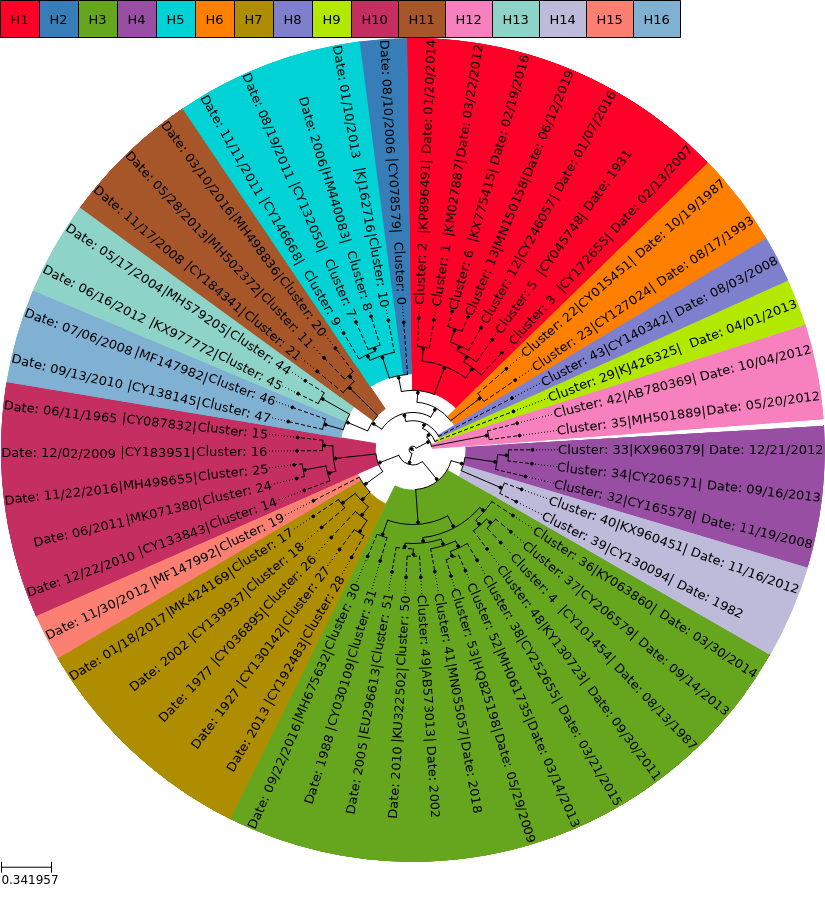

In [34]:
fasta = cluster.query('segment == 4 & centroid == True')    
align = fasta.join(genome)[['genome']]

msa = alignment(align, 6, outfolder + 'Guidetree_H.fasta', outfolder + 'Guidetree_H.msa')
#msa_dict = dict_alignment(msa, reduce = False, treshold = 1)

tree, tree_style = get_tree(cluster, upload, 4, 'H', tree_hex, collapse = False, path_phylo = outfolder + 'Guidetree_H.fasta.tree')
tree.render(outfolder + 'Guidetree_H.pdf', tree_style = tree_style)
tree.render('%%inline', tree_style = tree_style)

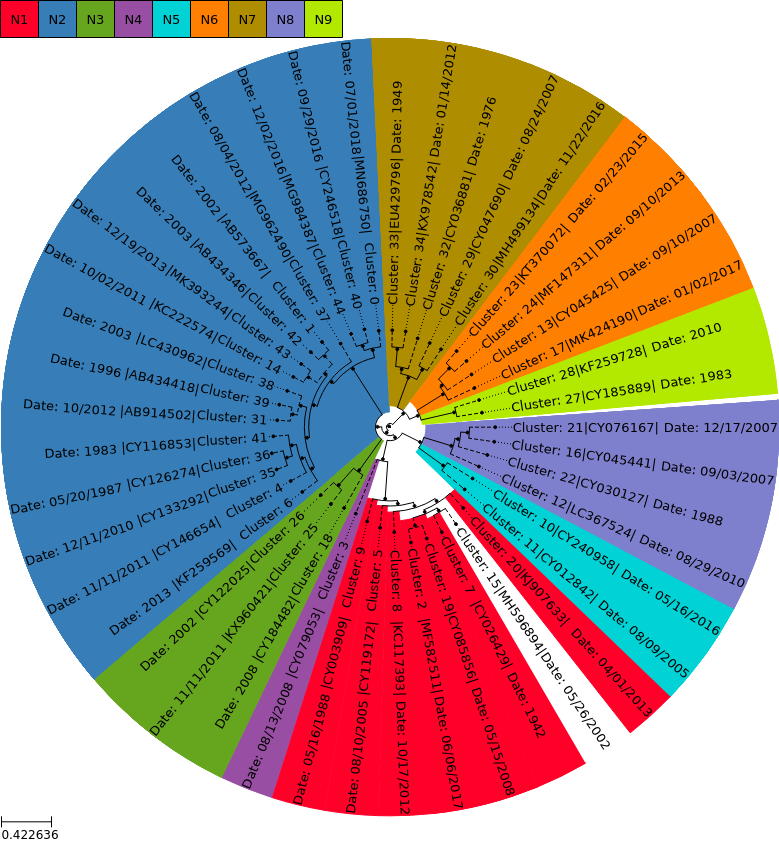

In [35]:
fasta = cluster.query('segment == 6 & centroid == True')    
align = fasta.join(genome)[['genome']]

msa = alignment(align, 6, outfolder + 'Guidetree_N.fasta', outfolder + 'Guidetree_N.msa')
#msa_dict = dict_alignment(msa, reduce = False, treshold = 1)

tree, tree_style = get_tree(cluster, upload, 6, 'N', tree_hex, collapse = False, path_phylo = outfolder + 'Guidetree_N.fasta.tree')
tree.render(outfolder + 'Guidetree_N.pdf', tree_style = tree_style)
tree.render('%%inline', tree_style = tree_style)

# H13/H14 Comparison